In [1]:

import pandas as pd
import numpy as np
from scipy.stats import skew
import warnings
import matplotlib
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet,Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
import seaborn as sns
# import xgboost as xgb


warnings.filterwarnings("ignore") 

%matplotlib inline

full_quarter_df=pd.read_csv("new_full_quarterData.csv")
#Lets read the data
# train =full_quarter_df[20:38]
# test =full_quarter_df.head(20)
train = full_quarter_df.head(20)
test =  full_quarter_df[20:37]
pd.options.display.max_columns = 200  # None -> No Restrictions
pd.options.display.max_rows = 20    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [2]:
#Data cleansing

all_data = pd.concat((train,
                      test))

#log transform the target:
# train[5] = np.log1p(train[5])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index  #Lets mark which features are very skewed.

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# all_data = pd.concat([all_data,pd.get_dummies(all_data['citypair'], prefix='segment')],axis=1)
# all_data = pd.concat([all_data,pd.get_dummies(all_data['aircraft'], prefix='plane')],axis=1)

# all_data.drop(['citypair'],axis=1, inplace=True)
# all_data.drop(['aircraft'],axis=1, inplace=True)

# bigFrame = pd.DataFrame({curr_year,curr_quarter})
# for name, group in all_data_1.groups :
#     print(name)
#     print(group)
#     print(str(year) +"-"+ str(quarter) +", " +citypair + " - "+ aircraft)
#     all_data_1.get_group(quarter, year, citypair, aircraft)
#     if curr_year==year and curr_quarter==quarter:
#         rowFrame=pd.DataFrame({citypair, aircraft,sum_departures_performed,sum_departures_scheduled,passengers,seats})
#         bigFrame=pd.concat(bigFrame,rowFrame)
#     else:
#         curr_year+=1
#         curr_quarter+=1
#         if curr_quarter ==5:
#             curr_quarter=1
#         newBigFrame = pd.DataFrame({curr_year,curr_quarter})
#         bigFrame=bigFrame.append(newBigFrame)
#         rowFrame=pd.DataFrame({citypair, aircraft,sum_departures_performed,sum_departures_scheduled,passengers,seats})
#         bigFrame=pd.concat(bigFrame,rowFrame)

# print(bigFrame)        
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(0)
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
# X_test.drop(['revenue'],axis=1, inplace=True)
y = train['revenue']
X_train

,year,quarter,fuel_price,stock_price,operational_expense,revenue,HOU-DAL-Boeing 737-300_flights_flown,HOU-DAL-Boeing 737-300_passengers_carried,DAL-HOU-Boeing 737-300_flights_flown,DAL-HOU-Boeing 737-300_passengers_carried,BUR-OAK-Boeing 737-700/700LR/Max 7_flights_flown,BUR-OAK-Boeing 737-700/700LR/Max 7_passengers_carried,OAK-BUR-Boeing 737-700/700LR/Max 7_flights_flown,OAK-BUR-Boeing 737-700/700LR/Max 7_passengers_carried,BUR-LAS-Boeing 737-700/700LR/Max 7_flights_flown,BUR-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-BUR-Boeing 737-700/700LR/Max 7_flights_flown,LAS-BUR-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-LAS-Boeing 737-700/700LR/Max 7_flights_flown,MDW-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,DAL-HOU-Boeing 737-700/700LR/Max 7_flights_flown,DAL-HOU-Boeing 737-700/700LR/Max 7_passengers_carried,PHX-SNA-Boeing 737-700/700LR/Max 7_flights_flown,PHX-SNA-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-PHX-Boeing 737-700/700LR/Max 7_flights_flown,MDW-PHX-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-PHX-Boeing 737-700/700LR/Max 7_flights_flown,LAS-PHX-Boeing 737-700/700LR/Max 7_passengers_carried,SNA-PHX-Boeing 737-700/700LR/Max 7_flights_flown,SNA-PHX-Boeing 737-700/700LR/Max 7_passengers_carried,PHX-SAN-Boeing 737-700/700LR/Max 7_flights_flown,PHX-SAN-Boeing 737-700/700LR/Max 7_passengers_carried,SAN-LAS-Boeing 737-700/700LR/Max 7_flights_flown,SAN-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,LAX-LAS-Boeing 737-700/700LR/Max 7_flights_flown,LAX-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,PHX-LAS-Boeing 737-700/700LR/Max 7_flights_flown,PHX-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-SAN-Boeing 737-700/700LR/Max 7_flights_flown,LAS-SAN-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-MDW-Boeing 737-700/700LR/Max 7_flights_flown,LAS-MDW-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-LAX-Boeing 737-700/700LR/Max 7_flights_flown,LAS-LAX-Boeing 737-700/700LR/Max 7_passengers_carried,SNA-OAK-Boeing 737-700/700LR/Max 7_flights_flown,SNA-OAK-Boeing 737-700/700LR/Max 7_passengers_carried,SMF-SAN-Boeing 737-700/700LR/Max 7_flights_flown,SMF-SAN-Boeing 737-700/700LR/Max 7_passengers_carried,SNA-SJC-Boeing 737-700/700LR/Max 7_flights_flown,SNA-SJC-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-RNO-Boeing 737-700/700LR/Max 7_flights_flown,LAS-RNO-Boeing 737-700/700LR/Max 7_passengers_carried,HOU-DAL-Boeing 737-700/700LR/Max 7_flights_flown,HOU-DAL-Boeing 737-700/700LR/Max 7_passengers_carried,OAK-LAX-Boeing 737-700/700LR/Max 7_flights_flown,OAK-LAX-Boeing 737-700/700LR/Max 7_passengers_carried,DAL-SAT-Boeing 737-700/700LR/Max 7_flights_flown,DAL-SAT-Boeing 737-700/700LR/Max 7_passengers_carried,SJC-SNA-Boeing 737-700/700LR/Max 7_flights_flown,SJC-SNA-Boeing 737-700/700LR/Max 7_passengers_carried,OAK-SNA-Boeing 737-700/700LR/Max 7_flights_flown,OAK-SNA-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-DEN-Boeing 737-700/700LR/Max 7_flights_flown,MDW-DEN-Boeing 737-700/700LR/Max 7_passengers_carried,SAN-SMF-Boeing 737-700/700LR/Max 7_flights_flown,SAN-SMF-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-MCO-Boeing 737-700/700LR/Max 7_flights_flown,MDW-MCO-Boeing 737-700/700LR/Max 7_passengers_carried,BUR-PHX-Boeing 737-700/700LR/Max 7_flights_flown,BUR-PHX-Boeing 737-700/700LR/Max 7_passengers_carried,SMF-BUR-Boeing 737-700/700LR/Max 7_flights_flown,SMF-BUR-Boeing 737-700/700LR/Max 7_passengers_carried,SAT-DAL-Boeing 737-700/700LR/Max 7_flights_flown,SAT-DAL-Boeing 737-700/700LR/Max 7_passengers_carried,PHX-BUR-Boeing 737-700/700LR/Max 7_flights_flown,PHX-BUR-Boeing 737-700/700LR/Max 7_passengers_carried,SMF-SNA-Boeing 737-700/700LR/Max 7_flights_flown,SMF-SNA-Boeing 737-700/700LR/Max 7_passengers_carried,BUR-SMF-Boeing 737-700/700LR/Max 7_flights_flown,BUR-SMF-Boeing 737-700/700LR/Max 7_passengers_carried,SNA-SMF-Boeing 737-700/700LR/Max 7_flights_flown,SNA-SMF-Boeing 737-700/700LR/Max 7_passengers_carried,SAN-PHX-Boeing 737-700/700LR/Max 7_flights_flown,SAN-PHX-Boeing 737-7

In [3]:
print(X_train.shape)
print(X_test.shape)

(20, 9348)
(17, 9348)


In [4]:
def rmse_cv(model, dataset):
    rmse= np.sqrt(-cross_val_score(model, dataset, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def outputPredictionToCSV(predictionData, filename):
    arr = test['year']
    arr2 = test['quarter']
#     arr3 = np.expm1(predictionData)
    arr3=predictionData
    df = pd.DataFrame(data=arr, columns = ["Year"])
    df.applymap(int) 
    
    df1 = pd.DataFrame(data=arr2, columns = ["Quarter"])
    df1.applymap(int)
    
    df2 = pd.DataFrame(data=arr3, columns = ['predict.revenue'])
        
    df4 = pd.concat([df,df1,df2], axis=1)
    dff = pd.DataFrame(data=df4) 
    dff.to_csv(filename+".csv", index=False)
    

def printRMSE_MSE(modelName,model,trainData):
    print(modelName +" has RMSE of "+ str(rmse_cv(model,trainData).mean()))
    yHat= model.predict(trainData) 
    print(modelName + " has MSE on train data is: "+ str(mean_squared_error(y,yHat)))
    
def printActuals(predictionData):
    act_data = test
    act_data=act_data.reset_index(drop=True)
#     print(act_data)
    arr3 = predictionData
    percentErrors =[]
    for x in range(len(act_data.revenue)):
#         print(act_data.revenue)
        
        percentError= (100*(abs(act_data.revenue[x]-arr3[x])/act_data.revenue[x]))
        print("Quarter : "+str(act_data.quarter[x])+" Year: "+str(act_data.year[x])+" : Actual: "+str(act_data.revenue[x])+" ,Prediction: "+str(arr3[x])+" ,Error: "+ str(percentError)+"%")
        percentErrors.append(percentError)
    print("Avg Percent Error is : "+str(sum(percentErrors) / len(percentErrors) ))
    
    
def printTopTenFeatures(model):
    import operator
    coeff_used = np.sum(model.coef_!=0)
    print("Number of Coeffients used: "+ str(coeff_used))
    coef_dict = {} 

    indexOfFeature =0

    for coef in model.coef_:
        if coef!=0: 
            coef_dict[X_train.columns[indexOfFeature]]=coef
        indexOfFeature+=1
    highestCoef_dict_sorted = sorted(coef_dict.items(), key=operator.itemgetter(1), reverse=True)[:5]
    print("Highest Coef: ")
    print(highestCoef_dict_sorted)
    lowestCoef_dict_sorted = sorted(coef_dict.items(), key=operator.itemgetter(1), reverse=False)[:5]
    print("Lowest Coef: ")
    print(lowestCoef_dict_sorted)
            
    

In [5]:
# ridge regression
modelForProblem1= Ridge(alpha=.1).fit(X_train, y)

printRMSE_MSE('ridge_regression_withGivenAlpha',modelForProblem1,X_train)

predictforModel1= modelForProblem1.predict(X_test)
outputPredictionToCSV(predictforModel1,'ridge_regression_withGivenAlpha_output')
print(X_train.shape)
printActuals(predictforModel1)
printTopTenFeatures(modelForProblem1)

ridge_regression_withGivenAlpha has RMSE of 29745.819578542163
ridge_regression_withGivenAlpha has MSE on train data is: 3.153510438891338e-16
(20, 9348)
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 4386490.960798537 ,Error: 0.6232224558555197%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 5075703.839500368 ,Error: 0.6905920661246793%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 5273906.771863706 ,Error: 0.8291317814271078%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 4941191.580147272 ,Error: 0.7194779958354034%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 4788884.194271676 ,Error: 0.7690801021202602%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 5324582.5699116215 ,Error: 1.103592683662305%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 5120584.893627625 ,Error: 0.3583402679971792%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 4921626.7521482725 ,Error: 0.3719280941645249%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Pre

In [6]:
# Find the best Alpha for a ridge regression and a lasso regression model.

alphas = [0.000005, 0.00005, 0.00001, 0.0005, 0.0001, 0.005, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 7, 8, 9,9.5, 10, 10.5, 11, 15, 30, 50, 75, 100]

cv_ridge = [rmse_cv(Ridge(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
print("The best ridge regression : "+str(cv_ridge.min()) +" with Alpha as " + str(cv_ridge.idxmin()))
print("The top five are:\n"+ str(cv_ridge.sort_values().head(5)))



cv_lasso = [rmse_cv(Lasso(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
print("\n\nThe best lasso regression : " +str(cv_lasso.min()) +" with Alpha as " + str(cv_lasso.idxmin()))
print("The top five are:\n"+ str(cv_lasso.sort_values().head(5)))

bestRidgeRegressionAlphaValue = cv_ridge.idxmin()
bestLassoRegressionAlphaValue = cv_lasso.idxmin()

The best ridge regression : 29745.81957851494 with Alpha as 5e-06
The top five are:
5.000e-06    29745.82
5.000e-05    29745.82
1.000e-04    29745.82
1.000e-05    29745.82
5.000e-04    29745.82
dtype: float64


The best lasso regression : 332191.4015361514 with Alpha as 30.0
The top five are:
30.0     332191.402
50.0     349701.500
75.0     355021.723
100.0    360122.037
15.0     369361.291
dtype: float64


In [7]:
# ridge regression with best alpha
modelForProblem2= Ridge(alpha = bestRidgeRegressionAlphaValue).fit(X_train, y)

printRMSE_MSE('ridge_regression_withBestAlpha',modelForProblem2,X_train)

predictforModel2= modelForProblem2.predict(X_test)
outputPredictionToCSV(predictforModel2,'ridge_regression_WithBestAlpha_output')
printActuals(predictforModel2)
printTopTenFeatures(modelForProblem2)

ridge_regression_withBestAlpha has RMSE of 29745.81957851494
ridge_regression_withBestAlpha has MSE on train data is: 2.2215302514227986e-17
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 4386490.960798552 ,Error: 0.6232224558551822%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 5075703.8395004105 ,Error: 0.690592066123841%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 5273906.771863756 ,Error: 0.8291317814261796%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 4941191.580147302 ,Error: 0.7194779958348045%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 4788884.194271705 ,Error: 0.7690801021196619%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 5324582.569911664 ,Error: 1.103592683661509%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 5120584.893627641 ,Error: 0.35834026799687113%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 4921626.752148299 ,Error: 0.371928094163997%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Prediction: 483241

In [8]:
# Lasso with best alpha
modelForProblem2b= Lasso(alpha = bestLassoRegressionAlphaValue).fit(X_train, y)

printRMSE_MSE('lasso_regression_withBestAlpha',modelForProblem2b,X_train)

predictforModel2b= modelForProblem2b.predict(X_test)
outputPredictionToCSV(predictforModel2b,'lasso_regression_WithBestAlpha_output')
printActuals(predictforModel2b)
printTopTenFeatures(modelForProblem2b)

lasso_regression_withBestAlpha has RMSE of 332191.4015361514
lasso_regression_withBestAlpha has MSE on train data is: 5.605593687505461e-05
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 3871073.7548686266 ,Error: 12.30009617424951%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 4734332.077154517 ,Error: 7.3697500067595945%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 4073402.421207547 ,Error: 23.403489635059284%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 4587522.549731493 ,Error: 7.825546519359193%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 3697025.206197858 ,Error: 23.393592909285996%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 4399017.630820274 ,Error: 18.29462052711229%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 4708605.523555279 ,Error: 8.37506278351277%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 5713769.3227626085 ,Error: 15.663346614627702%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Prediction: 4839491.8

In [9]:
# l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary the regularization hyperparameter alpha.

# coefDF=[]
# alphaDF=[]

# for x in alphas:
#     temp_lasso= Lasso(alpha = x).fit(X_train, y)
#     coef = pd.Series(temp_lasso.coef_, index = X_train.columns)
#     coefDF.append(sum(coef != 0))
#     alphaDF.append(x)

# dfAlpha =pd.DataFrame(data=alphaDF, columns = ['Alpha'])
# dfCoef =pd.DataFrame(data=coefDF, columns = ['None Zero Coefs'])

# dff2= pd.concat([dfAlpha,dfCoef], axis=1)

# print(dff2.head(10))

# plotThis = pd.DataFrame(data=dff2)
# plotThis.plot()

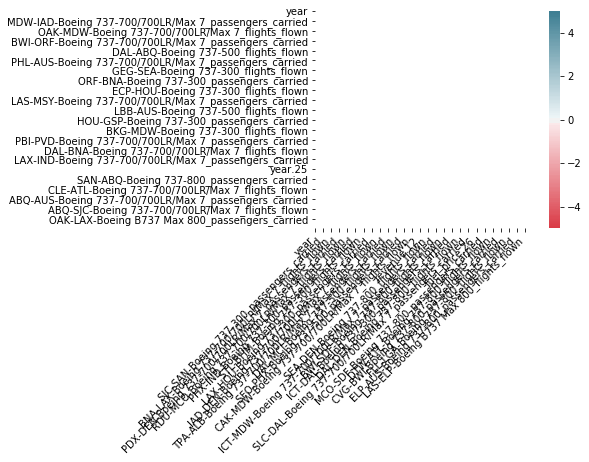

In [10]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-5, vmax=5, center=0,
    cmap=sns.diverging_palette(10, 220, sep=5, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);